# Init

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
# Torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms as T

In [3]:
# Get device for torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


# Load Dataset

In [4]:
# Data transforms
data_transform = T.Compose([T.ToTensor(), T.Lambda(lambda x: torch.flatten(x))])
target_transform = T.Compose([T.Lambda(lambda x:torch.LongTensor([x])), T.Lambda(lambda x:F.one_hot(x,10)), T.Lambda(lambda x: torch.flatten(x))])

In [5]:
# Download/read data
train_dataset = datasets.FashionMNIST('./dataset', train=True, download=True, transform=data_transform, target_transform=target_transform)
test_dataset = datasets.FashionMNIST('./dataset', train=False, download=True, transform=data_transform, target_transform=target_transform)

In [6]:
# Create data loaders
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=10000, shuffle=True)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10000, shuffle=True)

In [7]:
# Labels map
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

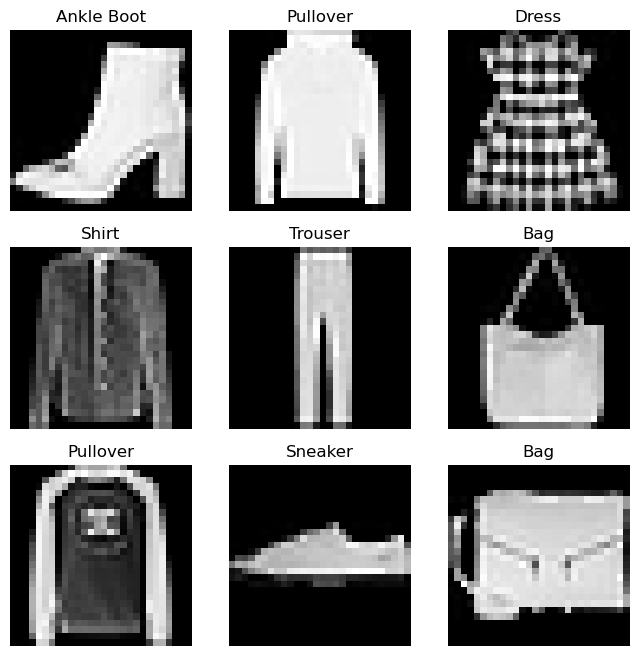

In [8]:
# Inspect random datapoints
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[torch.argmax(label).item()])
    plt.axis("off")
    plt.imshow(img.reshape((28, 28)), cmap="gray")
plt.show()

# Model

In [9]:
# Class for neural net model
class MLPModel(nn.Module):

    # Constructor
    def __init__(self, input_shape, output_shape, layer_shapes):
        super().__init__()

        # Get input and output dims
        assert len(input_shape) <= 2, "Invalid input shape"
        assert len(output_shape) <= 2, "Invalid output shape"
        assert len(layer_shapes), "Invalid layer shape data"
        self.input_dims = input_shape[-1] if len(input_shape) == 2 else 1
        self.output_dims = output_shape[-1] if len(output_shape) == 2 else 1
        
        # Create weight and bias matrices
        weights = []
        biases = []
        for i, layer in enumerate(layer_shapes):
            previous_dim = self.input_dims if i==0 else layer_shapes[i-1]
            weights.append(nn.init.xavier_uniform_(torch.ones(previous_dim, layer)))
            biases.append(nn.init.xavier_uniform_(torch.zeros(1,layer)))
        weights.append(nn.init.xavier_uniform_(torch.ones(layer_shapes[-1], self.output_dims)))
        biases.append(nn.init.xavier_uniform_(torch.zeros(1, self.output_dims)))

        # Create nn parameters from the weights and biases
        self.weights = nn.ParameterList([nn.Parameter(w, requires_grad=True) for w in weights])
        self.biases = nn.ParameterList([nn.Parameter(b, requires_grad=True) for b in biases])

    # Forward pass
    def forward(self, input):

        # Loop all weights except last
        current_layer = input
        for i in range(len(self.weights)) :

            # Print
            current_layer = torch.relu(torch.mm(current_layer, self.weights[i]) + self.biases[i])

        # Return output after softmax
        output = current_layer
        # output = torch.softmax(current_layer, 1)
        return output

In [10]:
# Function to train one epoch
def train_model(dataloader, model, optimizer):

    # Initialize variables
    size = len(dataloader.dataset)
    size_d = len(str(size))
    num_batches = len(dataloader)
    total_loss = 0
    correct = 0

    # Set model training mode
    model.train()

    # Loop batches
    for batch, (X, y) in enumerate(dataloader):

        # Move data to device
        X, y = X.to(device), y.to(device)

        # Calculate outputs
        outputs = model(X)

        # Calculate losses
        loss = F.cross_entropy(outputs, y.float())
        loss.backward()
        total_loss += loss.item()

        # Optimize
        optimizer.step()
        optimizer.zero_grad()

        # Print batch stats
        targets = torch.argmax(y, dim=1)
        correct += (outputs.argmax(1) == targets).type(torch.float).sum().item()
        loss, current = loss.item(), (batch + 1) * len(X)
        print(f"loss: {loss:>7f}  [{current:>{size_d}d}/{size:>{size_d}d}]")

    # Calculate average loss and accuracy
    avg_loss = total_loss / num_batches
    accuracy = correct / size

    # Return average loss and accuracy
    return avg_loss, accuracy

In [11]:
# Test function to run every epoch
def test_model(dataloader, model, optimizer):

    # Initialize variables
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0
    correct = 0

    # Set model evaluation mode
    model.eval()

    # Calulate loss
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            targets = torch.argmax(y, dim=1)
            loss = F.cross_entropy(outputs, targets)
            test_loss += loss.item()
            correct += (outputs.argmax(1) == targets).type(torch.float).sum().item()

    # Get accuracy and avg batch loss
    avg_loss = test_loss / num_batches
    accuracy = correct / size
    
    # Print loss
    print(f"\nTest Error: \nAccuracy: {(100*accuracy):>0.1f}%, \nAvg loss: {avg_loss:>8f} \n")
    
    # Return accuracy and average batch loss
    return avg_loss, accuracy

# Training

#### Create model and optimizer

In [42]:
# Hyperparameters
learning_rate = 0.05
epochs = 200

In [43]:
# Get a sample batch to get shapes for creating model
sample_batch_data, sample_batch_label = next(iter(train_data_loader))
data_shape = sample_batch_data.shape
target_shape = sample_batch_label.shape

In [44]:
# Define hidden layer structure
hidden_layers = [512, 512]

In [45]:
# Create model object
model = MLPModel(data_shape, target_shape, hidden_layers)
model.to(device)

MLPModel(
  (weights): ParameterList(
      (0): Parameter containing: [torch.float32 of size 784x512 (cuda:0)]
      (1): Parameter containing: [torch.float32 of size 512x512 (cuda:0)]
      (2): Parameter containing: [torch.float32 of size 512x10 (cuda:0)]
  )
  (biases): ParameterList(
      (0): Parameter containing: [torch.float32 of size 1x512 (cuda:0)]
      (1): Parameter containing: [torch.float32 of size 1x512 (cuda:0)]
      (2): Parameter containing: [torch.float32 of size 1x10 (cuda:0)]
  )
)

In [46]:
# Optimizer
optimizer = SGD(model.parameters(), lr=learning_rate)

#### Train model

In [47]:
# Metrics
metrics = []

# Run epochs
for epoch in range(epochs):

    # Log epoch details
    print(f"Epoch {epoch+1}/{epochs}\n-------------------------------")

    # Train model
    train_loss, train_accuracy = train_model(train_data_loader, model, optimizer)

    # Test model
    test_loss, test_accuracy = test_model(test_data_loader, model, optimizer)

    # Add metrics to array
    metrics.append({
        'train_loss': train_loss,
        'train_accuracy': train_accuracy,
        'test_loss': test_loss,
        'test_accuracy': test_accuracy
    })

Epoch 1/200
-------------------------------
loss: 2.373576  [10000/60000]
loss: 2.255258  [20000/60000]
loss: 2.194930  [30000/60000]
loss: 2.145310  [40000/60000]
loss: 2.088477  [50000/60000]
loss: 2.051388  [60000/60000]

Test Error: 
Accuracy: 46.2%, 
Avg loss: 2.007088 

Epoch 2/200
-------------------------------
loss: 2.008171  [10000/60000]
loss: 1.956222  [20000/60000]
loss: 1.937160  [30000/60000]
loss: 1.895442  [40000/60000]
loss: 1.861734  [50000/60000]
loss: 1.828026  [60000/60000]

Test Error: 
Accuracy: 51.5%, 
Avg loss: 1.805261 

Epoch 3/200
-------------------------------
loss: 1.808037  [10000/60000]
loss: 1.773137  [20000/60000]
loss: 1.745171  [30000/60000]
loss: 1.715536  [40000/60000]
loss: 1.724098  [50000/60000]
loss: 1.680815  [60000/60000]

Test Error: 
Accuracy: 54.7%, 
Avg loss: 1.668952 

Epoch 4/200
-------------------------------
loss: 1.672274  [10000/60000]
loss: 1.640460  [20000/60000]
loss: 1.623664  [30000/60000]
loss: 1.617450  [40000/60000]
loss:

#### Analyze model

In [48]:
# Create dataframe from metrics
df = pd.DataFrame(metrics)
df

,train_loss,train_accuracy,test_loss,test_accuracy
0,2.184823,0.278033,2.007088,0.4620
1,1.914459,0.485583,1.805261,0.5151
2,1.741132,0.530750,1.668952,0.5467
3,1.609387,0.556817,1.526114,0.5756
4,1.476314,0.588433,1.433671,0.5936
...,...,...,...,...
195,0.395853,0.862750,0.436330,0.8432
196,0.399473,0.860200,0.442891,0.8407
197,0.404852,0.858033,0.443679,0.8408
198,0.410795,0.854750,0.440860,0.8441


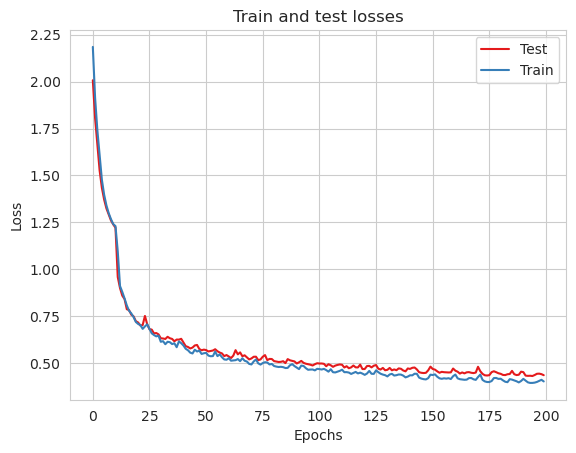

In [49]:
# Plot train and test losses
sns.set_style('whitegrid')
sns.set_palette("Set1")
sns.lineplot(df['test_loss'], label='Test')
sns.lineplot(df['train_loss'], label='Train')
plt.title('Train and test losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

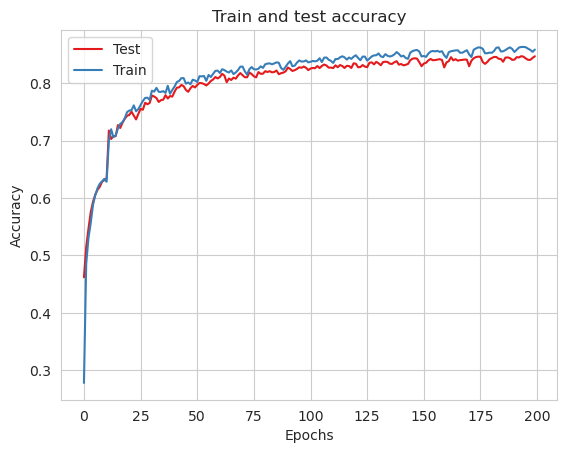

In [50]:
# Plot train and test accuracy
sns.set_style('whitegrid')
sns.set_palette("Set1")
sns.lineplot(df['test_accuracy'], label='Test')
sns.lineplot(df['train_accuracy'], label='Train')
plt.title('Train and test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()